In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from src.data.datasets import ModelParamsDataset

from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.model.models import DBModelSmall, DBModelBig, Autoencoder

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from src.visualization.visualize import plot_interpolation, plot_decision_boundary

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Small models

In [2]:
# Hyperparameters
epochs = 100
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 2
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = Autoencoder(latent_dim=latent_dim, dropout=dropout)
model = DBModelSmall()
model.requires_grad_(False)

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv")
train_indices, test_indices, _, _ = train_test_split(range(len(dataset)), dataset.angles, stratify=dataset.angles, test_size=0.2, random_state=random_seed)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../../models/autoencoders/autoencoder_dbloss"
model_path = "{}/model_final.pth".format(path)

## Train

In [ ]:
autoencoder.train()
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in train_dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        reconstructed = autoencoder(parameters_batch)
        model.set_weights(reconstructed)
        output = model(input)

        # Ground truth
        model.set_weights(parameters_batch)
        goal = model(input)

        optimizer.zero_grad()
        loss = loss_fn(output, goal)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    if(epoch % 5 == 0):
        torch.save(autoencoder.state_dict(), f"{path}/checkpoint_{epoch}.pth")

torch.save(autoencoder.state_dict(), model_path)

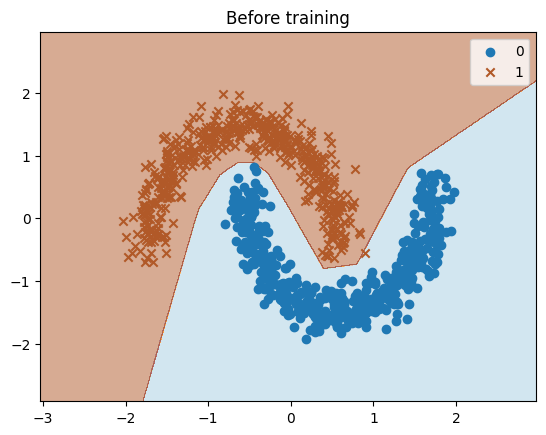

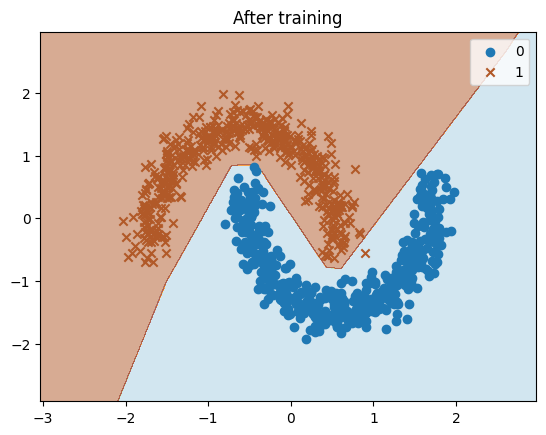

In [3]:
autoencoder = Autoencoder(latent_dim=latent_dim, dropout=dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()
model = DBModelSmall(batch_first=False)

index = 10000
parameters = train_dataset[index][0].unsqueeze(0)
angle = train_dataset[index][1]
reconstructed = autoencoder(parameters)
X, y = get_moons_dataset()
X_rotated = rotate(X, angle)

model.set_weights(parameters.squeeze())
plot_decision_boundary(model, X_rotated, y, title="Before training")
model.set_weights(reconstructed.squeeze())
plot_decision_boundary(model, X_rotated, y, title="After training")

## Latent space

(100000, 2)


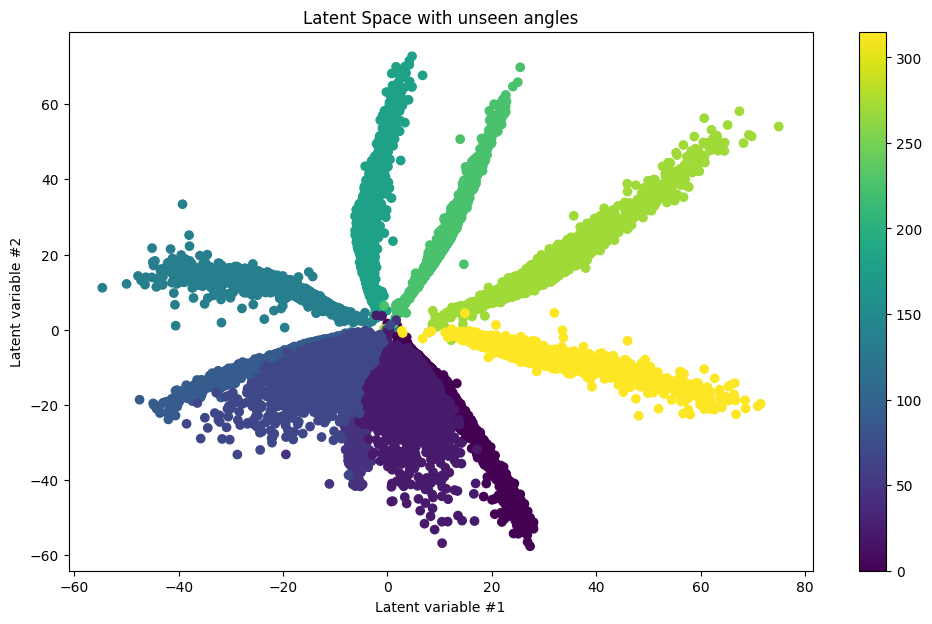

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

autoencoder = Autoencoder(latent_dim=latent_dim, dropout=dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../../data/zoo_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

raw_unseen = pd.read_csv("../../data/extra_angles.csv")
weights_unseen = raw_unseen.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles_unseen = raw_unseen["angle"].to_numpy()

# Join both weights
weights = np.vstack([weights, weights_unseen])
angles = np.hstack([angles, angles_unseen])

weights = torch.tensor(weights).float()
latent = autoencoder.encoder(weights).detach().numpy()

print(latent.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()
img = ax.scatter(latent[:, 0], latent[:, 1], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')


plt.title("Latent Space with unseen angles")
plt.xlabel("Latent variable #1")
plt.ylabel("Latent variable #2")
plt.show()

## Reconstructed weigths distribution

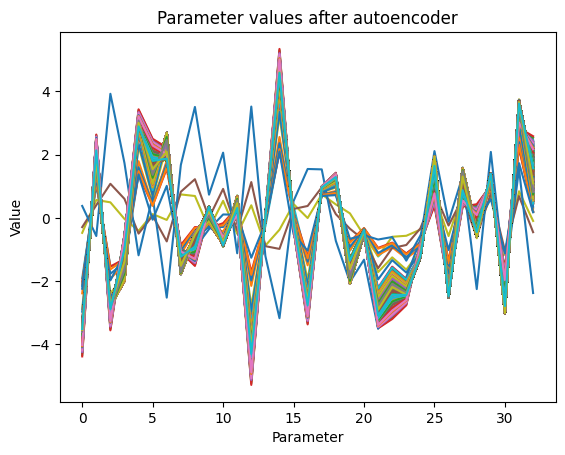

In [10]:
from matplotlib import pyplot as plt

dataset = ModelParamsDataset("../../data/zoo_small.csv")


autoencoder = Autoencoder(latent_dim=latent_dim, dropout=dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

reconstruction = []
for i in range(10000):
    parameters = dataset[i][0].unsqueeze(0)
    r = autoencoder(parameters)
    r = r.squeeze().detach().numpy()
    reconstruction.append(r)


for r in reconstruction:
    plt.plot(r)

plt.xlabel("Parameter")
plt.ylabel("Value")
plt.title("Parameter values after autoencoder")
plt.show()

## Accuracy distribution

  0%|          | 0/16000 [00:00<?, ?it/s]

Mean trained accuracy: 99.8715
Mean reconstructed accuracy: 99.82848750000002


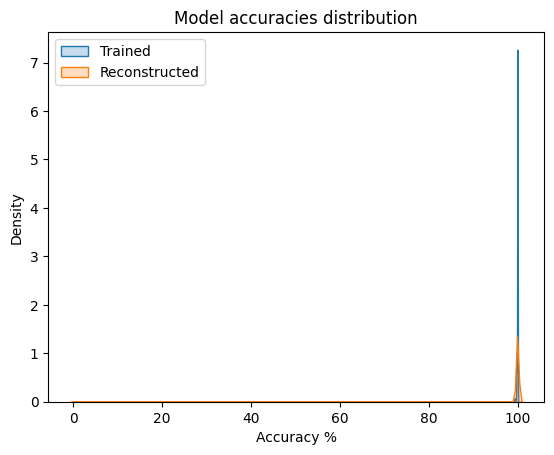

In [13]:
autoencoder = Autoencoder(latent_dim=latent_dim, dropout=dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()
model = DBModelSmall(batch_first=False)

trained_accuracies = []
reconstructed_accuracies = []

X, y = get_moons_dataset()

for (parameter, angle) in tqdm(test_dataset):
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)

    model.set_weights(parameter)
    accuracy = get_accuracy(model, X_rotated, y)
    trained_accuracies.append(accuracy)


    reconstructed = autoencoder(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()
    model.set_weights(reconstructed)
    accuracy = get_accuracy(model, X_rotated, y)
    reconstructed_accuracies.append(accuracy)

print(f"Mean trained accuracy: {np.mean(trained_accuracies)}")
print(f"Mean reconstructed accuracy: {np.mean(reconstructed_accuracies)}")

sns.kdeplot(trained_accuracies, fill=True, label="Trained")
sns.kdeplot(reconstructed_accuracies, fill=True, label="Reconstructed")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
plt.show()


## Interpolation

  0%|          | 0/7 [00:00<?, ?it/s]

Mean interpolation accuracy: 97.38428


Text(0.5, 0, 'Accuracy %')

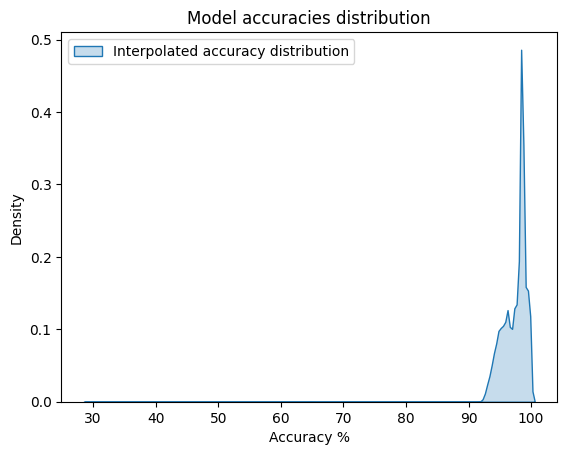

In [14]:
autoencoder = Autoencoder(latent_dim=latent_dim, dropout=dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

model = DBModelSmall(batch_first=False)

raw = pd.read_csv("../data/zoo_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()
accuracies = []
for i in tqdm(range(0, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.3, 0.7)

        latent_1 = autoencoder.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        latent_2 = autoencoder.encoder(torch.tensor(weight_2).float().unsqueeze(0))
        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = autoencoder.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        model.set_weights(w)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy(model, X_rotated, y)
        accuracies.append(accuracy)
    
print("Mean interpolation accuracy:", np.mean(accuracies))

sns.kdeplot(accuracies, fill=True, label="Interpolated accuracy distribution")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
# plt.show()

In [16]:
def plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha):
    db = DBModelSmall(batch_first=False)
    parameters_1, angle_1 = datapoint_1
    parameters_2, angle_2 = datapoint_2

    parameters_1 = parameters_1.unsqueeze(0)
    parameters_2 = parameters_2.unsqueeze(0)

    latent_1 = model.encoder(parameters_1)
    latent_2 = model.encoder(parameters_2)

    latent = (1-alpha)*latent_1 + alpha*latent_2
    w = model.decoder(latent).squeeze()

    angle = (1-alpha)*angle_1 + alpha*angle_2
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float()
    db.set_weights(w)
    plot_decision_boundary(db, X_rotated, y)

In [18]:
autoencoder = Autoencoder(latent_dim=latent_dim, dropout=dropout)

autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../../data/zoo_small.csv")

X, y = get_moons_dataset()

alpha = 0.8
index_1 = 0
index_2 = 60000

datapoint_1 = dataset[index_1]
datapoint_2 = dataset[index_2]

interact(plot_interpolation, model=fixed(autoencoder), datapoint_1=fixed(datapoint_1), datapoint_2=fixed(datapoint_2), X=fixed(X), y=fixed(y), alpha=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5))

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

<function __main__.plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha)>

# Big models

In [21]:
# Hyperparameters
epochs = 100
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 2
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = Autoencoder(in_out_dim=261, latent_dim=latent_dim, dropout=dropout)
model = DBModelBig()

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

# Dataset
dataset = ModelParamsDataset("../../data/zoo_big.csv")
train_indices, test_indices, _, _ = train_test_split(range(len(dataset)), dataset.angles, stratify=dataset.angles, test_size=0.2, random_state=random_seed)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../../models/autoencoders/autoencoder_dbloss"
model_path = "{}/model_big_final.pth".format(path)

In [ ]:
autoencoder.train()
losses = []

for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in train_dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        reconstructed = autoencoder(parameters_batch)
        model.set_weights(reconstructed)
        output = model(input)

        # Ground truth
        model.set_weights(parameters_batch)
        goal = model(input)

        optimizer.zero_grad()
        loss = loss_fn(output, goal)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    losses.append(total_loss)

torch.save(autoencoder.state_dict(), model_path)

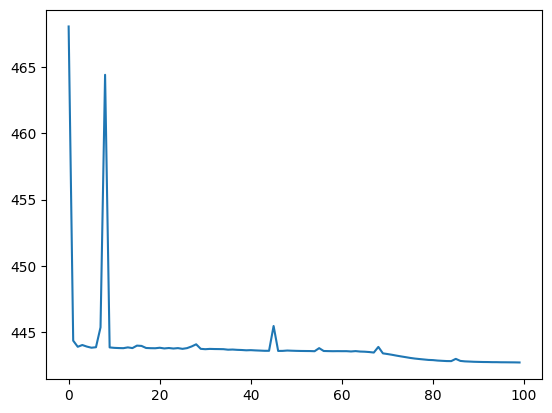

In [9]:
plt.plot(losses)

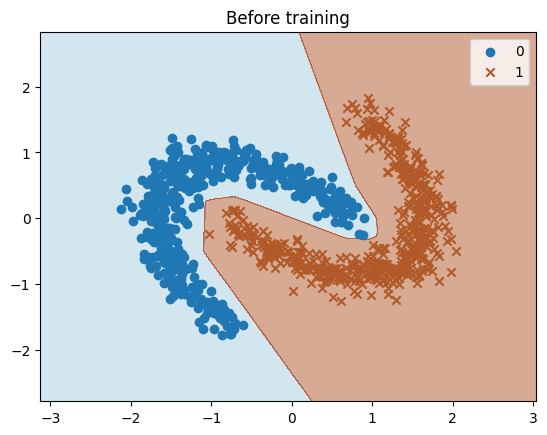

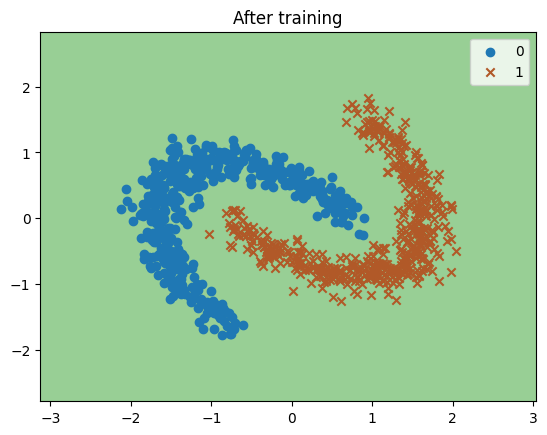

In [25]:
autoencoder = Autoencoder(in_out_dim=261, latent_dim=latent_dim, dropout=dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()
model = DBModelBig(batch_first=False)

index = 4201
parameters = train_dataset[index][0].unsqueeze(0)
angle = train_dataset[index][1]
reconstructed = autoencoder(parameters)
X, y = get_moons_dataset()
X_rotated = rotate(X, angle)
model.set_weights(parameters.squeeze())
plot_decision_boundary(model, X_rotated, y, title="Before training")
model.set_weights(reconstructed.squeeze())
plot_decision_boundary(model, X_rotated, y, title="After training")